In [241]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [2]:
import pandas as pd
admission_table=pd.read_csv('data/ADMISSIONS.csv')
notes_table=pd.read_csv('data/NOTEEVENTS.csv')
data_merged = pd.merge(notes_table, admission_table, how='left', on=['SUBJECT_ID', 'HADM_ID'])

/Users/apple/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [302]:
valid_subject = pd.read_csv('data/id_inhospital_deathtime.csv', index_col = 0)

In [116]:
# take the first addmission time 
admission_table['ADMITTIME']=admission_table['ADMITTIME'].map(lambda x: parser.parse(x))
sub_hops_admission = admission_table.groupby(['SUBJECT_ID'])['ADMITTIME'].unique()
sub_hops_admission = sub_hops_admission.map(lambda x: sorted(x)[0])

In [117]:
first_adm = pd.DataFrame({'SUBJECT_ID': sub_hops_admission.index,'ADMITTIME':sub_hops_admission.values })
first_adm = pd.merge(first_adm, admission_table, how = 'left', on = ['SUBJECT_ID','ADMITTIME' ] )
id_first = set(first_adm['HADM_ID'])
label = [x in id_first for x in data_merged['HADM_ID'] ]

In [119]:
len(first_adm)

46520

In [120]:
data_merged = data_merged[label]

In [121]:
len(data_merged)

1312330

In [122]:
len(notes_table)

2083180

In [33]:
data_merged = data_merged[~pd.isnull(data_merged['CHARTTIME'])]

In [34]:
len(data_merged)

1312330

In [42]:
data_merged.columns

Index(['ROW_ID_x', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT',
       'ROW_ID_y', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
       'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME',
       'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [41]:
data_merged['DISCHARGE_LOCATION'].unique()

array(['SNF', 'DEAD/EXPIRED', 'HOME', 'REHAB/DISTINCT PART HOSP',
       'HOME HEALTH CARE', 'LONG TERM CARE HOSPITAL', 'HOSPICE-HOME',
       'HOSPICE-MEDICAL FACILITY', 'DISCH-TRAN TO PSYCH HOSP',
       'SHORT TERM HOSPITAL', 'LEFT AGAINST MEDICAL ADVI',
       'OTHER FACILITY', 'ICF', 'DISC-TRAN TO FEDERAL HC',
       'DISC-TRAN CANCER/CHLDRN H', 'HOME WITH HOME IV PROVIDR',
       'SNF-MEDICAID ONLY CERTIF'], dtype=object)

In [43]:
data_merged['CATEGORY'].unique()

array(['Nursing', 'Physician ', 'Respiratory ', 'Nutrition', 'General',
       'Case Management ', 'Pharmacy', 'Rehab Services', 'Social Work',
       'Consult', 'Radiology', 'Nursing/other'], dtype=object)

In [49]:
sum(pd.isnull(data_merged['DEATHTIME']))/len(data_merged)

0.0

In [81]:
type(data_merged['DEATHTIME'][308691])

float

In [82]:
data_merged['DEATHTIME']= [parser.parse(x) if type(x)!=float else x for x in data_merged['DEATHTIME']]
data_merged['DEATHTIME'] = pd.to_datetime(data_merged['DEATHTIME'])
print('DEATHTIME')

DEATHTIME


In [66]:
data_merged['ADMITTIME']=data_merged['ADMITTIME'].map(lambda x: parser.parse(x))
print('ADMITTIME')
data_merged['DISCHTIME']=data_merged['DISCHTIME'].map(lambda x: parser.parse(x))
print('DISCHTIME')
data_merged['CHARTTIME']=data_merged['CHARTTIME'].map(lambda x: parser.parse(x))
print('CHARTTIME')

ADMITTIME
DISCHTIME
CHARTTIME


In [127]:
time_only = data_merged[~pd.isnull(data_merged['DEATHTIME'])][['SUBJECT_ID','CHARTTIME', 'DISCHTIME','DEATHTIME']]
len(time_only[time_only['DEATHTIME'] != time_only['DISCHTIME']]['SUBJECT_ID'].unique())

40

In [147]:
subject_ID_list = data_merged['SUBJECT_ID'].unique()
print( sum(data_merged.groupby(['SUBJECT_ID'])['DISCHTIME'].nunique() != 1))
print( sum(data_merged.groupby(['SUBJECT_ID'])['ADMITTIME'].nunique() != 1))
print( sum(data_merged.groupby(['SUBJECT_ID'])['DEATHTIME'].nunique() > 1))

0
0


/Users/apple/anaconda3/lib/python3.5/site-packages/pandas/core/groupby.py:2919: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


0


In [154]:
CHARTTIMElist = data_merged.groupby(['SUBJECT_ID'])['CHARTTIME'].unique()
ADMITTIMElist = data_merged.groupby(['SUBJECT_ID'])['ADMITTIME'].unique()
DEATHTIMElist = data_merged.groupby(['SUBJECT_ID'])['DEATHTIME'].unique()
DISCHTIMElist = data_merged.groupby(['SUBJECT_ID'])['DISCHTIME'].unique()

In [155]:
sub_time_dictionary = {}
for sub in subject_ID_list:
    sub_time_dictionary[sub] = {}
    sub_time_dictionary[sub]['CHARTTIME'] = CHARTTIMElist[sub]
    sub_time_dictionary[sub]['ADMITTIME'] = ADMITTIMElist[sub]
    sub_time_dictionary[sub]['DEATHTIME'] = DEATHTIMElist[sub]
    sub_time_dictionary[sub]['DISCHTIME'] = DISCHTIMElist[sub]

In [179]:
with open('patient_timesheet.pickle', 'rb') as handle:
     sub_time_dictionary = pickle.load(handle)

In [163]:
len(time_only['SUBJECT_ID'].unique())

4091

In [210]:
subject_adult = valid_subject['SUBJECT_ID']

In [181]:
for sub in subject_ID_list:
    sub_time_dictionary[sub]['CHARTTIME_valid'] = [x for x in sub_time_dictionary[sub]['CHARTTIME'] 
                                                   if x < sub_time_dictionary[sub]['DISCHTIME']]

In [227]:
error_sub = []
for sub in subject_ID_list:
    try:
        sub_time_dictionary[sub]['CHARTTIME_interval'] = (sub_time_dictionary[sub]['CHARTTIME_valid'] - 
                                                          sub_time_dictionary[sub]['ADMITTIME']).astype('timedelta64[m]')
    except TypeError:
        #print(sub)
        error_sub.append(sub)

In [217]:
error_adult = []
for sub in error_sub:
    if sub_time_dictionary[sub]['ADMITTIME'] > sub_time_dictionary[sub]['DEATHTIME'] and sub in subject_adult:
        #print('error',sub)
        error_adult.append(sub)
    else:
        pass
    
        #print(sub)

/Users/apple/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: In the future, 'NAT > x' and 'x > NAT' will always be False.
  app.launch_new_instance()


In [268]:
time_interval = np.array([15, 6*60, 12*60, 24*60]).astype('timedelta64[m]')


notes_counts = {}
for sub in subject_ID_list:
    try:
        sub_list = np.zeros(5)
        for interval in sub_time_dictionary[sub]['CHARTTIME_interval']:
            if interval<=time_interval[0]:
                sub_list[0] += 1
            elif interval<=time_interval[1]:
                sub_list[1] += 1
            elif interval<=time_interval[2]:
                sub_list[2] += 1
            elif interval<=time_interval[3]:
                sub_list[3] += 1
            else:
                sub_list[4] += 1
        notes_counts[sub] = sub_list
    except KeyError:
        #print(sub)
        #error_sub.append(sub)
        pass    

In [269]:
notes_counts_table = pd.DataFrame(notes_counts).T

In [270]:
notes_counts_table.columns  = ['15 minutes', '6 hours', '12 hours', '24 hours', 'Over 24 hours']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x23edb77b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2483b4400>]], dtype=object)

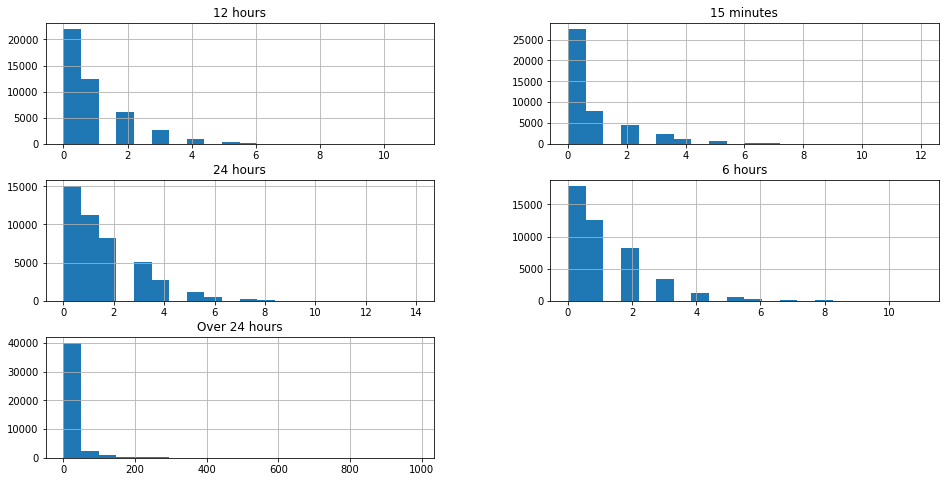

In [272]:
notes_counts_table.hist(figsize = (16,8), bins = 20)

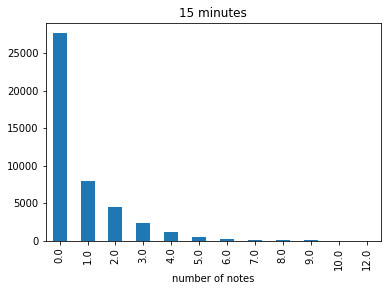

In [292]:
notes_counts_table['15 minutes'].value_counts().plot.bar(title = '15 minutes')
plt.xlabel('number of notes')

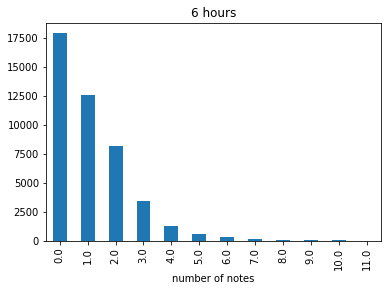

In [293]:
notes_counts_table['6 hours'].value_counts().plot.bar(title = '6 hours')
plt.xlabel('number of notes')


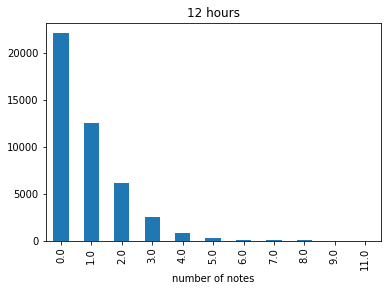

In [294]:
notes_counts_table['12 hours'].value_counts().plot.bar(title = '12 hours')
plt.xlabel('number of notes')


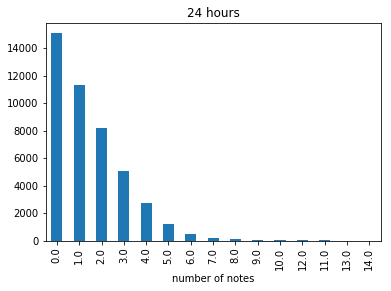

In [295]:
notes_counts_table['24 hours'].value_counts().plot.bar(title = '24 hours')
plt.xlabel('number of notes')




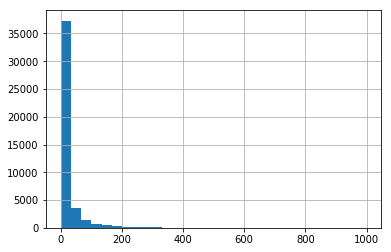

In [296]:
notes_counts_table.sum(1).hist(bins = 30)

In [291]:
sum(notes_counts_table.sum(1) < 3)

5258

In [287]:
len(notes_counts_table)

44445

In [297]:
notes_counts_table.sum(0)

15 minutes        33746.0
6 hours           50517.0
12 hours          37798.0
24 hours          65706.0
Over 24 hours    912799.0
dtype: float64

In [305]:
notes_counts_table['SUBJECT_ID'] = notes_counts_table.index

In [301]:
np.sum(notes_counts_table['15 minutes']>0)

16830

In [307]:
with_death = pd.merge(notes_counts_table, valid_subject, how = 'left', on = ['SUBJECT_ID'])

In [311]:
with_death = with_death[~pd.isnull(with_death['DEATHTIME'])]

In [312]:
with_death.sum(0)

15 minutes                                                    4843
6 hours                                                       4887
12 hours                                                      4300
24 hours                                                      7678
Over 24 hours                                               126723
SUBJECT_ID                                               156070067
DEATHTIME        2149-11-14 10:15:002104-08-20 02:57:002135-02-...
dtype: object

In [313]:
4843/33746

0.14351330528062586